# Methylize Walkthrough

In [ ]:
#Install joblib module for parallelization
import sys
!conda install --yes --prefix {sys.prefix} joblib

In [2]:
import methylize
import methylcheck
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

## Differentially Methylated Position Analysis with Binary Phenotypes

DMPs are **probes** where methylation levels differ between two groups of samples, while DMRs are **genomic regions** where DNA methylation levels differ between two groups of samples.

Beta or m-values can be used, but the format needs to be samples as rows and probes as columns.

In [3]:
betas, meta = methylcheck.load_both('../data/asthma') #load in the beta values and metadata
betas = betas.T
print(meta.shape)
meta.head()

INFO:methylcheck.load_processed:Found several meta_data files; attempting to match each with its respective beta_values files in same folders.
INFO:methylcheck.load_processed:Multiple meta_data found. Only loading the first file.
INFO:methylcheck.load_processed:Loading 40 samples.
Files: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]
INFO:methylcheck.load_processed:loaded data (485512, 40) from 1 pickled files (0.1s)
INFO:methylcheck.load_processed:Transposed data and reordered meta_data so sample ordering matches.
INFO:methylcheck.load_processed:meta.Sample_IDs match data.index (OK)


(40, 19)


,tissue,disease,smoking_status,passage,Sex,age,description,Sample_ID,Sentrix_ID,Sentrix_Position,Sample_Group,Sample_Name,Sample_Plate,Sample_Type,Sub_Type,Sample_Well,Pool_ID,GSM_ID,Control
20,Airway Fibroblast,Healthy,Ex,4,M,65,fun2norm normalized average beta,9976861129_R03C01,9976861129,R03C01,None,HAF091,None,Unknown,None,None,None,GSM4772065,False
38,Parenchymal Fibroblast,Asthmatic,Non,4,F,19,fun2norm normalized average beta,9976861129_R04C02,9976861129,R04C02,None,7294_P4_LG,None,Unknown,None,None,None,GSM4772083,False
37,Parenchymal Fibroblast,Asthmatic,Non,4,F,14,fun2norm normalized average beta,9976861129_R05C01,9976861129,R05C01,None,7291_lg_p4,None,Unknown,None,None,None,GSM4772082,False
32,Parenchymal Fibroblast,Asthmatic,Current,4,F,15,fun2norm normalized average beta,9976861129_R06C02,9976861129,R06C02,None,7188_lg_p4_R,None,Unknown,None,None,None,GSM4772077,False
23,Airway Fibroblast,Asthmatic,Non,4,F,8,fun2norm normalized average beta,9976861137_R06C01,9976861137,R06C01,None,7016_BR_P4,None,Unknown,None,None,None,GSM4772068,False


### Get binary phenotype

The phenotypes can be anything list-like (i.e. a list, numpy array, or Pandas series). 

When using Logistic Regression DMP, use phenotype data that is binary (has only 2 classes). In this example, we will take disease state as our phenotype because there are only 2 classes, Asthmatic and Healthy. The DMP step will automatically convert your string phenotype to `0` and `1` if there are not in that format already.

(40,)


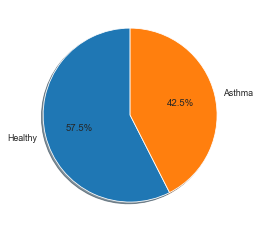

In [4]:
pheno_data = meta.disease
print(pheno_data.shape)
dummies = pd.get_dummies(meta, columns=['disease'])[['disease_Asthmatic', 'disease_Healthy']]
healthy = dummies.disease_Healthy.sum()
asthma = dummies.disease_Asthmatic.sum()
fig1, ax1 = plt.subplots()
ax1.pie((healthy, asthma), labels=['Healthy', 'Asthma'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

### DMP Function

This function searches for individual differentially methylated positions/probes (DMPs) by regressing the methylation beta or M-value for each sample at a given genomic location against the phenotype data for those samples. In this first example, we are using the argument `regression_method="logistic"` because we are using binary phenotypes.

`impute` argument:

* Default: ‘delete’ probes if any samples have missing data for that probe. 
* True or ‘auto’: if <30 samples, deletes rows; if >=30 samples, uses average. 
* False: don’t impute and throw an error if NaNs present ‘average’ - use the average of probe values in this batch ‘delete’ - drop probes if NaNs are present in any sample 
* ‘fast’ - use adjacent sample probe value instead of average (much faster but less precise)

Note: if you want to analyze every probe in your betas dataframe, remove the `.sample(N)`. What this does is randomly samples `N` probes from your dataframe and decreases the time it takes to complete this analysis.

In [5]:
test_results = methylize.diff_meth_pos(betas.sample(20000, axis=1), pheno_data, regression_method="logistic", export=False)
print(test_results.shape)
test_results.head()

All samples with the phenotype (Asthmatic) were assigned a value of 0 and all samples with the phenotype (Healthy) were assigned a value of 1 for the logistic regression analysis.


  0%|          | 0/17035 [00:00<?, ?it/s]

(17035, 6)


,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue
cg18705846,1.392240,1.419384,0.326654,-1.389702,4.174181,0.547143
cg14494733,0.350032,0.352583,0.320824,-0.341017,1.041082,0.547143
cg02617312,6.411514,4.361812,0.141583,-2.137481,14.960509,0.547143
cg26745332,10.005271,8.914112,0.261689,-7.466068,27.476609,0.547143
cg18432877,0.308049,0.356014,0.386889,-0.389726,1.005824,0.547143


## Differentially Methylated Positions Analysis with Continuous Numeric Phenotypes

### Get Continuous Numeric Phenotype

In order to find DMPs against a numeric continuous phenotype, the `linear` regression method must be used.

In this example, we are using age as the continuous numeric phenotype.

(40,)


Text(0, 0.5, 'Frequency')

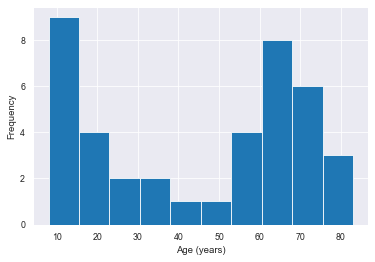

In [6]:
pheno_data = meta.age.astype(int)
print(pheno_data.shape)
(pheno_data.sort_values()).hist()
plt.xlabel('Age (years)'); plt.ylabel('Frequency')

### DMP Function

In this second example, we are using the argument `regression_method="linear"` because we are using continuous numeric phenotypes.

In [7]:
test_results2 = methylize.diff_meth_pos(betas, pheno_data, regression_method="linear", export=False)
print(test_results2.shape)
test_results2.head()

  0%|          | 0/414373 [00:00<?, ?it/s]

(414373, 7)


,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,Rsquared,FDR_QValue
cg03555227,0.004583,0.000380,1.453304e-14,0.890321,0.890629,0.792946,6.022099e-09
cg16867657,0.008122,0.000718,9.888059e-14,0.877810,0.878454,0.771117,2.048672e-08
cg11169102,-0.004757,0.000460,1.323437e-12,-0.859258,-0.858785,0.737918,1.550767e-07
cg16909962,0.009223,0.000903,1.871221e-12,0.855763,0.856707,0.733140,1.550767e-07
cg23045594,0.005227,0.000511,1.856802e-12,0.856031,0.856566,0.733247,1.550767e-07


## Manhattan Plots

After we run the DMP analysis, we can move on to visualizing the results. One way to do this is a Manhattan plot.

A Manhattan plot has probe position on the x-axis (grouped and colored by chromosome) and `-log(p-value)` on the y-axis. Because of the scale on the y-axis, the greater the probe is on the y-axis, the more significant that probe is to the phenotype that was used. It is common to have a cutoff on Manhattan plots where we set our α, which commonly is `0.05`. Other common α are `0.01` and `0.001`. The lower your α is, the more significant probes are that are above that cufoff on the Manhattan plot. The cutoff is for the p-values, meaning the probe is statistically significant if the p-value < α. 

Because there are a high number of probes, a p-value correction is needed to prevent false positives. The Manhattan plot function automatically applies a Bonferroni correction to the cutoff to lower the α (increase the dotted cutoff line on the plot) to a more conservative value. The post-test correction is controlled by the `post_test` argument, where `"bonferroni"` is the default, and other options are `"fdr"` for an FDR correction, and `None` for no post-test correction to keep the cutoff the same as is entered in the `cutoff` argument.



### Manhattan Plot for Binary Phenotypes

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450k_15017482_v3.csv


Total probes to plot: 17035
01 1693 | 02 1248 | 03 916 | 04 663 | 05 857 | 06 1289 | 07 1043 | 08 717 | 09 321 | 10 873 | 11 999 | 12 872 | 13 414 | 14 567 | 15 502 | 16 739 | 17 972 | 18 226 | 19 949 | 20 365 | 21 123 | 22 301 | X 386


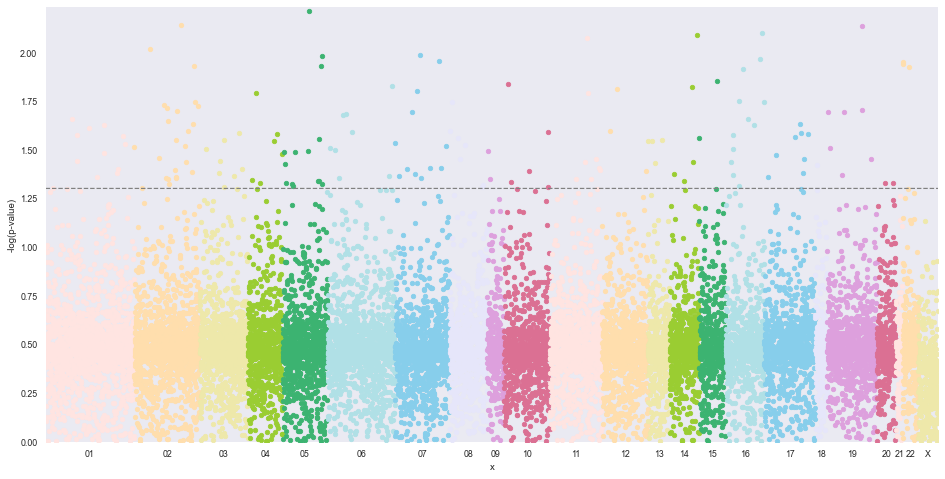

In [8]:
methylize.manhattan_plot(test_results, cutoff=0.05, palette='default', save=False, array_type='450k', post_test=None)

#### Find Significant Probes

To see which probes are significant (above the cutoff line in the Manhattan plot), filter the results dataframe by the p-value. Because we set `post_test=None` in the arguments, this means the p-value cutoff that was set is correct, and there was no correction to this value. The next DMR example will have a p-value correction.

In [9]:
interesting_probes = test_results[test_results['PValue'] <= 0.05]
interesting_probes

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue,minuslog10pvalue,chromosome,MAPINFO
cg04684267,4.722065,1.761226,0.007338,1.270126,8.174004,0.547143,2.134451,19,CHR-58183135.0
cg17561241,13.262314,5.935791,0.025464,1.628377,24.896251,0.547143,1.594080,12,CHR-53676510.0
cg21584241,8.847238,3.603801,0.014089,1.783917,15.910558,0.547143,1.851105,15,CHR-63049264.0
cg22166290,4.398436,1.940517,0.023413,0.595093,8.201779,0.547143,1.630547,02,CHR-60553348.0
cg07437373,3.995459,1.907912,0.036246,0.256020,7.734898,0.547143,1.440735,03,CHR-134406972.0
...,...,...,...,...,...,...,...,...,...
cg05387167,4.925943,2.212470,0.025984,0.589582,9.262303,0.547143,1.585288,17,CHR-48552442.0
cg10982364,6.972084,2.980323,0.019316,1.130757,12.813410,0.547143,1.714078,02,CHR-199464947.0
cg13366537,3.633572,1.806448,0.044278,0.092998,7.174146,0.547143,1.353808,07,CHR-29990138.0
cg18273840,20.466402,9.303763,0.027821,2.231362,38.701442,0.547143,1.555624,05,CHR-45695541.0


### Manhattan Plot for Continuous Numeric Phenotypes

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450k_15017482_v3.csv


Total probes to plot: 414373
01 40528 | 02 30059 | 03 21877 | 04 17328 | 05 20851 | 06 30620 | 07 24564 | 08 17814 | 09 8501 | 10 20863 | 11 25272 | 12 21229 | 13 10370 | 14 12956 | 15 12921 | 16 18404 | 17 24069 | 18 5215 | 19 21756 | 20 9259 | 21 3329 | 22 7167 | X 9419 | Y 2


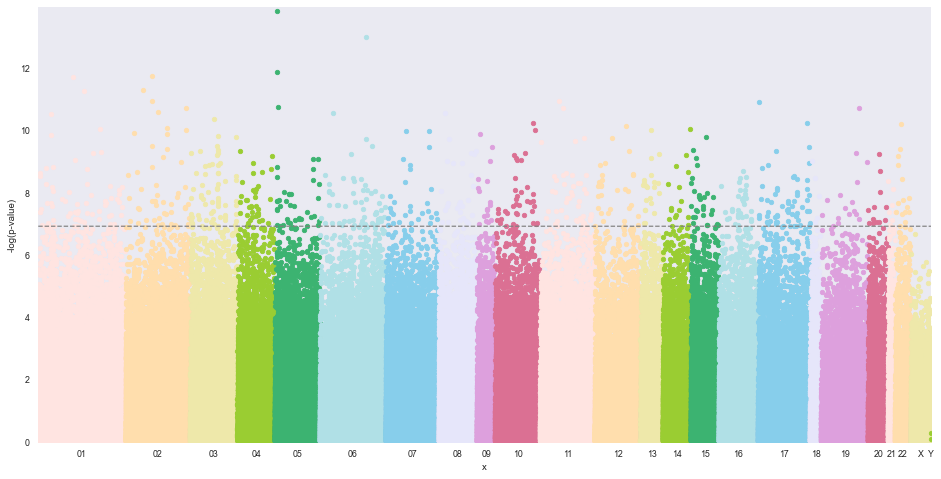

In [10]:
methylize.manhattan_plot(test_results2, cutoff=0.05, palette='default', save=False, array_type='450k', verbose=True)

#### Find Significant Probes

For this Manhattan plot, there has been a p-value cuttoff correction, meaning that the cutoff line is at a more conservative value (lower p-value, higher cutoff line) to account for false positives. Because of this correction, when filtering the results dataframe to find significant probes, you need to filter by the Bonferoni (or FDR) adjust p-value to find the probes above the cutoff line on the Manhattan plot.

In [11]:
adjusted = multipletests(test_results2.PValue, alpha=0.05)
pvalue_cutoff_y = -np.log10(adjusted[3])
interesting_probes2 = test_results2[test_results2['minuslog10pvalue'] >= pvalue_cutoff_y] #bonferoni correction for cutoff
interesting_probes2

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,Rsquared,FDR_QValue,minuslog10pvalue,chromosome,MAPINFO
cg03555227,0.004583,0.000380,1.453304e-14,0.890321,0.890629,0.792946,6.022099e-09,13.837644,05,CHR-170862066.0
cg16867657,0.008122,0.000718,9.888059e-14,0.877810,0.878454,0.771117,2.048672e-08,13.004889,06,CHR-11044644.0
cg11169102,-0.004757,0.000460,1.323437e-12,-0.859258,-0.858785,0.737918,1.550767e-07,11.878297,05,CHR-170858836.0
cg16909962,0.009223,0.000903,1.871221e-12,0.855763,0.856707,0.733140,1.550767e-07,11.727875,01,CHR-229270964.0
cg23045594,0.005227,0.000511,1.856802e-12,0.856031,0.856566,0.733247,1.550767e-07,11.731235,02,CHR-71276753.0
...,...,...,...,...,...,...,...,...,...,...
cg04091914,-0.003923,0.000604,1.185223e-07,-0.726027,-0.724906,0.526302,6.947979e-05,6.926200,02,CHR-227686822.0
cg25874108,-0.002309,0.000355,1.190858e-07,-0.725717,-0.725057,0.526186,6.947979e-05,6.924140,17,CHR-74896813.0
cg01235463,-0.002696,0.000415,1.188893e-07,-0.725800,-0.725029,0.526227,6.947979e-05,6.924857,10,CHR-91154018.0
cg11126313,-0.001694,0.000261,1.199705e-07,-0.725505,-0.725020,0.526006,6.972307e-05,6.920925,03,CHR-46242771.0


## Volcano Plot

`Logistic Regression Volcano Plots are under construction`

Below shows how to create a Volcano plot using the linear regression DMR analysis. 

Positive correlation (**hypermethylated**) in <font color='red'>red</font>.
Negative correclation (**hypomethylated**) in <font color='blue'>blue</font>

A higher `|beta coefficient|` means that that specific probe is more significant in predicting if the probe is methylated (positive) vs not methylated (negative). The non-gray probes are the probes that are statistically significant, and have a higher absolute value of the regression coefficient as the cutoff. The red probes further to the right on the plot are hypermethylated with increase in age, and the opposite is true for the blue probes.

Useful Arguments:

* `cutoff`: Default: 0.05 alpha level The significance level that will be used to highlight the most significant adjusted p-values (FDR Q-values) on the plot. This is the horizontal cutoff line you see on the plot.

* `beta_coefficient_cutoff`: Default: No cutoff format: a list or tuple with two numbers for (min, max) If specified in kwargs, will exclude values within this range of regression coefficients from being “significant” and put dotted vertical lines on chart. These are the vertical cutoff lines you see on the plot. These cutoffs are dependent on the study and up to the researcher in choosing which cutoff is the most desirable.

Excluded 269865 probes outside of the specified beta coefficient range: (-0.0005, 0.0005)


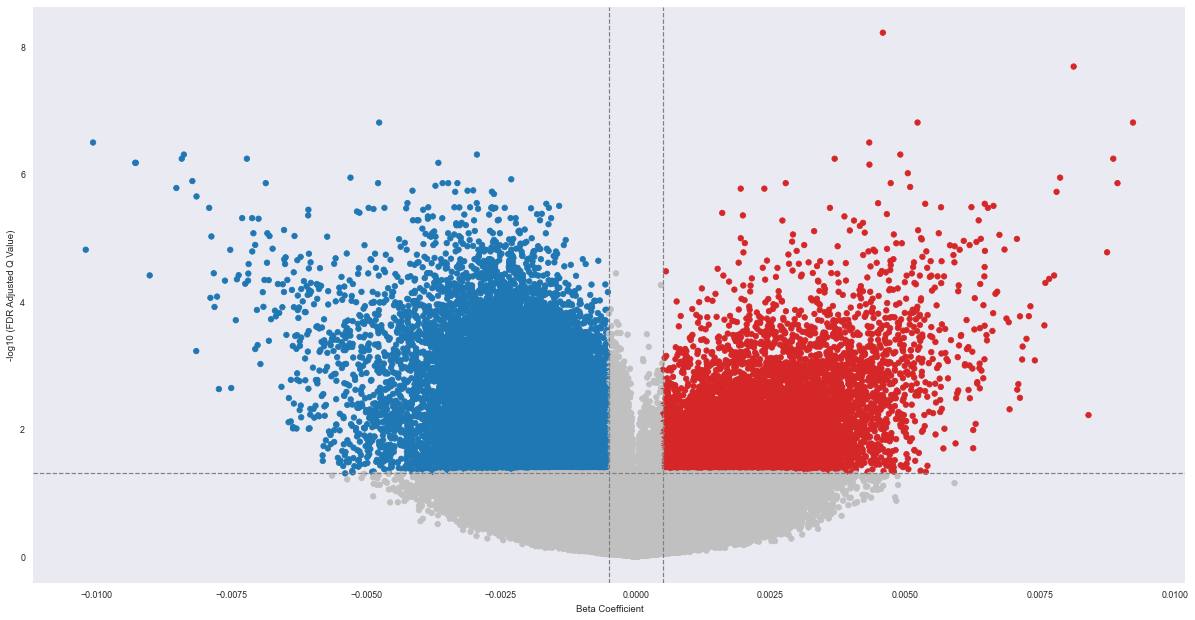

In [12]:
methylize.volcano_plot(test_results2, fontsize=16, cutoff=0.05, beta_coefficient_cutoff=(-0.0005,0.0005), save=False)

### Find Significant Probes

In [13]:
interesting_probes3 = test_results2[(test_results2['FDR_QValue'] <= 0.05) & (np.abs(test_results2['Coefficient']) > 0.0005)]
interesting_probes3

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,Rsquared,FDR_QValue,minuslog10pvalue,chromosome,MAPINFO
cg03555227,0.004583,0.000380,1.453304e-14,0.890321,0.890629,0.792946,6.022099e-09,13.837644,05,CHR-170862066.0
cg16867657,0.008122,0.000718,9.888059e-14,0.877810,0.878454,0.771117,2.048672e-08,13.004889,06,CHR-11044644.0
cg11169102,-0.004757,0.000460,1.323437e-12,-0.859258,-0.858785,0.737918,1.550767e-07,11.878297,05,CHR-170858836.0
cg16909962,0.009223,0.000903,1.871221e-12,0.855763,0.856707,0.733140,1.550767e-07,11.727875,01,CHR-229270964.0
cg23045594,0.005227,0.000511,1.856802e-12,0.856031,0.856566,0.733247,1.550767e-07,11.731235,02,CHR-71276753.0
...,...,...,...,...,...,...,...,...,...,...
cg18227216,-0.000972,0.000331,5.680062e-03,-0.430024,-0.428965,0.184466,4.997593e-02,2.245647,17,CHR-10225251.0
cg16297435,0.001548,0.000528,5.681080e-03,0.428642,0.430330,0.184459,4.997954e-02,2.245569,06,CHR-43060558.0
cg05515570,-0.000716,0.000244,5.681038e-03,-0.429877,-0.429096,0.184459,4.997954e-02,2.245572,10,CHR-28125056.0
cg13346820,-0.001955,0.000667,5.680922e-03,-0.430553,-0.428421,0.184460,4.997954e-02,2.245581,05,CHR-865203.0


## Differentiated Methylized Regions (DMR) Analysis

DMRs are **genomic regions** where DNA methylation levels differ between two groups of samples, while DMPs are **probes** where methylation levels differ between two groups of samples. DMR looks at clusters or adjacent probes, and if the whole cluster shows the same direction of effect between groups, then it is more significant (likely to be meaningful). 

We have already ran `methylize.diff_meth_pos` with the continuous numeric phenotypes, and the statistics for that fuction is stored in the dataframe `test_restuls2`. This is what we will use in the DMR function below.

This following step should create these files:
* dmr.acf.txt

* dmr.args.txt

* dmr.fdr.bed.gz

* dmr.manhattan.png

* dmr.regions-p.bed.gz

* dmr.slk.bed.gz

* dmr_regions.csv

* dmr_regions_genes.csv

* dmr_stats.csv

* stats.bed

This could run for a while. This function compares all of the probes and clusters CpG probes that show a difference together if they are close to each other in the genomic sequence. 

There are many adjustible parameters for the following function, and you can refer to the [API Reference](https://life-epigenetics-methylize.readthedocs-hosted.com/en/feature-v0.9.9-docs/docs/source/modules.html#module-methylize.diff_meth_regions) for more information.

In [14]:
files_created = methylize.diff_meth_regions(test_results2, '450k', prefix='../data/asthma/dmr/')

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450k_15017482_v3.csv
INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450k_15017482_v3.csv
/Users/jaredmeyers/opt/anaconda3/lib/python3.8/site-packages/methylize/diff_meth_regions.py:150: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  results = _pipeline(kw['col_num'], kw['step'], kw['dist'],
Calculating ACF out to: 453
with 17 lags: [1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361, 391, 421, 451, 481]
18581032 bases used as coverage for sidak correction
INFO:methylize.diff_meth_regions:wrote: ../data/asthma/dmr/.regions-p.bed.gz, (regions with corrected-p < 0.05: 29)
/var/folders/3k/vrkjxj8s7l1gq4x6n7ymqncw0000gn/T/ipykernel_39006/1491901786.py:1: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  files_created = methylize.diff_meth_regions(test_results2, '450k', prefix='../data/a

Many of the files created by this function can be useful when using other tools. The file with the main summary of what was just done is found in `dmr_regions_genes.csv`.

In [15]:
regions_genes = pd.read_csv('../data/asthma/dmr_regions_genes.csv')
regions_genes.head()

,Unnamed: 0,chrom,chromStart,chromEnd,min_p,n_probes,z_p,z_sidak_p,name,genes,distances,descriptions
0,0,1,22289407,22289457,0.03571,1,0.000094,0.7979,cg02053477,NaN,NaN,NaN
1,1,1,34757646,34757696,0.03110,1,0.000054,0.6018,cg13170235,SNRPC,142,Homo sapiens small nuclear ribonucleoprotein p...
2,2,1,34761106,34761156,0.03401,1,0.000081,0.7500,cg15750705,NaN,NaN,NaN
3,3,1,202858152,202858202,0.03110,1,0.000038,0.4790,cg15569630,NaN,NaN,NaN
4,4,10,22334619,22334669,0.03110,1,0.000038,0.4790,cg13327545,NaN,NaN,NaN


This shows clusters of CpG probes that were significantly different and annotes these clusters with mne or more nearby genes using the UCSV Genome Browswer database. 

Distances are the number of base-pairs that separate the start of the CpG probe and the start of the coding sequence of the gene. 

Only the rows with signicicant p-values will have an annotation.

Adopted from the ``combined-pvalues`` package by Brend Pedersen et al, 2013: Comb-p: software for combining, analyzing, grouping and correcting spatially correlated P-values doi: [10.1093/bioinformatics/bts545](10.1093/bioinformatics/bts545)

More information on DMR on [this page](https://life-epigenetics-methylize.readthedocs-hosted.com/en/feature-v0.9.9-docs/docs/diff_meth_regions.html#how-to-run-dmr)